# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: 네이버 영화리뷰 감성분석에 SentencePiece 적용해보기</span>
<NLP기초>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
      -1. Tokenize (SentencePiece)
      -2. 학습데이터 전처리
      -3. Split Validation 

    2-3. 모델 학습  
    2-4. 데이터 평가   

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


[SentencePiece](https://github.com/google/sentencepiece) 는 Google 에서 제공하고 있는 Tokenizer / Detokenizer 이다.  

Tokenize 란 NLP 에서 중요한 부분인 '단어사전 제작' 을 의미한다.

직관적으로 생각했을 때, 단어사전은 단어별, 형태소별, 혹은 그 사이 어떤 경계를 나누어 만들 수 있다.

Sentencepiece 는
BPE 와 unigram 이라는 두 가지의 분리 방법을 통해 subword tokenizing model 을 제공하고 있다.  

최근 pretrained model 은 대부분 SentencePiece 를 Tokenizer 로 설정하는 추세이기에 NLP 분야 tokenizer 의 표준이라고 표현해도 과언이 아니다.

오늘은 이러한 SentencePiece 를 끌어와 사용하는 것까지를 실습해보기로 한다.  

실습에 쓰이는 데이터는  
SentencePiece 토크나이저를 학습시킬 [한국어 corpus](https://github.com/jungyeul/korean-parallel-corpora) 와  
모델을 학습시킬  [Naver_Moive txt data](https://github.com/e9t/nsmc/blob/master/ratings_test.txt) 로 한다.

오늘의 rubric

|평가문항|상세기준|
|--|--|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

## 1-2. 사용하는 라이브러리

In [ ]:
! python3 --version

Python 3.7.12


In [ ]:
#import konlpy 단순 import 는 에러 발생

시작 하기전 Konlpy 라이브러리에 특이사항이 있다.  
colab에서는 Konlpy 를 install 할때 별도의 과정을 거쳐야 한다.

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

import konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [80.4 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://developer.download.nvi

In [ ]:
#주요 라이브러리 버전 확인

import tensorflow as tf #NLP 모델 생성
import numpy as np #데이터 배열 처리
import matplotlib as plt #시각화
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.8.0
1.21.5
3.2.2
0.6.0


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [ ]:
#이 외 라이브러리

import matplotlib.pyplot as plt #시각화 라이브러리 pyplot
import pandas as pd #데이터 배열
import sentencepiece as spm #우리가 사용할 Tokenizer

from google.colab import files 
import io # kolab 데이터 경로 라이브러리


In [ ]:
# LSTM 라이브러리

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

# 2. GAME
## 2-1. 데이터 읽어오기

깃허브에서는 NLP 학습을 위해 일반 이용자들이 다양한 말뭉치를 제공해주고 있다.

그 중 [여기](https://github.com/e9t/nsmc/) 에서는 네이버의 영화 리뷰에 대한 말뭉치를 제시한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ratings_train.txt to ratings_train.txt
Saving ratings_test.txt to ratings_test.txt


In [ ]:
train_data= pd.read_table(io.StringIO(uploaded['ratings_train.txt'].decode('utf-8')))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test_data = pd.read_table(io.StringIO(uploaded['ratings_test.txt'].decode('utf-8')))

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2-2.데이터 전처리

### 2-2-1. Tokenizer 생성

우리가 단어사전을 만들기 위해 사용할  
데이터는 따로 있다. 더 크고 방대한  
한국어 자료를 사용해 더 명료하고 명확한  
한국어 단어 사전을 만들 것이다.

In [ ]:
corpus_path = '/content/drive/MyDrive/Colab_Notebooks/Aiffel/data/korean-english-park.train.ko'

with open(corpus_path, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


이전에 이 자료를 탐색 및 분석했기 때문에 EDA 과정은 생략하고 바로 전처리에 들어가도록 하겠다.  

전처리 과정은
> 1. 중복데이터 삭제
2. `max_len` = 150
3. `min_len` = 10
4. `padding` 처리

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


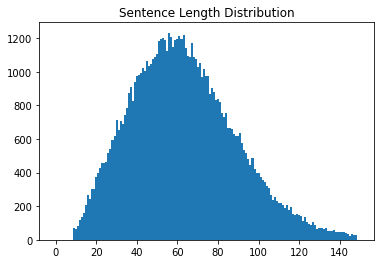

In [ ]:
cleaned_corpus = list(set(raw)) # 1.중복제거

max_len = 150 # 2번
min_len = 10 #3번

# 길이 조건에 맞는 문장 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도로 시각화.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

해당 데이터를 SentencePiece 라이브러리를 통해 

Tokenize 시킨다.

In [ ]:
temp_file = '/content/drive/MyDrive/Colab_Notebooks/Aiffel/data/korean-english-park.train.ko.temp'

vocab_size = 8000

model_type = 'bpe'
with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    f'--input={temp_file} --model_prefix=korean_spm --vocab_size={vocab_size} --model_type={model_type}'    #korean_spm 에 저장
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.


!ls -l korean_spm*

-rw-r--r-- 1 root root 371954 Mar 23 03:11 korean_spm.model
-rw-r--r-- 1 root root 117142 Mar 23 03:11 korean_spm.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된다. 이후에는  

korean_spm.model 파일과  
korean_spm.vocab vocabulary 파일이 root에 생성된다.

다음은 이렇게 학습한 model 데이터의 활용이다.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


`EncodeAsIds` = 글자를 벡터화 리스트로 반환

`SampleEncodeAsPieces` = 글자를 나눈 방법을 리스트로 반환

`DecodeIds` = 벡터화 리스트를 글자로 변환

해당 SentencePiece 를 영화 리뷰 데이터로 Tokenize 하기 위한 코드는 다음과 같다.

In [ ]:
# s = spm.SentencePieceProcessor()
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen)) # 문장이 벡터화된 리스트로 변환되어 tensor 에 입력

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word}) #word_to_index 저장
        index_word.update({word:idx}) #index_to)word 저장

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # tensor 문장 중 가장 긴 문장을 기준으로 패딩

    return tensor, word_index, index_word

### 2-2-2. 학습 데이터 전처리

이제는 학습시키기 위해 영화리뷰 데이터를 전처리하도록 한다.

1. 오타 등 필요없는 문자 제거
2. 중복값 제거
3. 결측값 제거


In [ ]:

def preprocessing(train_data, test_data):
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글이 아닌 문자를 공백으로 변환

    train_data['document'] = train_data['document'].str.replace('^ +', "")
    train_data['document'].replace('', np.nan, inplace=True)

    test_data['document'] = test_data['document'].str.replace('^ +', "") #긴 공백을 공백으로 변경
    test_data['document'].replace('', np.nan, inplace=True)  # 공백을 NaN 으로 변경

    train_data.drop_duplicates(subset=['document'], inplace=True) 
    test_data.drop_duplicates(subset=['document'], inplace=True) #중복값 제거

    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') #결측치 제거

    return train_data, test_data
  
train, test = preprocessing(train_data, test_data)

train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print(train.isnull().values.any())
print(test.isnull().values.any())


False
False


In [ ]:
print(len(train), len(test))

144975 48751


길이 분포를 확인하고 적절한 크기로 padding 한다.

문장의 최단 길이: 1
문장의 최장 길이: 145
문장의 평균 길이: 36



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 

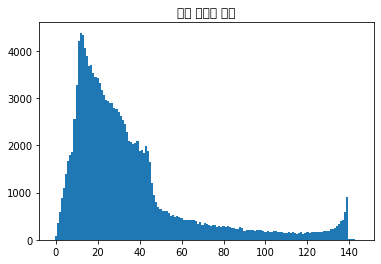

In [ ]:
# 데이터 길이 분포 확인하기

min_len = 999
max_len = 0
sum_len = 0

for sen in train['document']:
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length: 
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length: 
        max_len = length
        
    # 전체 문장총 길이
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

# 전체 길이만큼 0벡터 ==> 길이에 따른 문장의 수를 저장하기 위해 먼저 0으로 이루어진 리스트를 만든다!!
sentence_length = np.zeros((max_len), dtype=np.int)
print('')


for sen in train['document']:
    sentence_length[len(sen)-1] += 1 # 0으로 이루어진 벡터에 문장 count를 더한 뒤 넣는다.

plt.bar(range(max_len), sentence_length, width=1.0) # 너비는 1.0씩 늘어나도록 설정
plt.title("문장 길이별 분포")
plt.show()

In [ ]:
min_list = [s for s in train['document'] if (len(s) <= 2)]

min_list[:10]


['최고', '졸작', '대박', '아', '점', '버려', '망함', '굳굳', '안습', '잼']

데이터 분포를 고려하여 45이하 데이터를 사용하도록 하겠다.

원래는 2글자 이하 데이터도 제거하려 하였으나,  
위 데이터를 보고 충분히 유의미하다고 느꼈다.

In [ ]:
train_list = [s for s in train['document'] if (len(s) <= 35)]
test_list = [s for s in test['document'] if (len(s) <= 35)]

train_df = pd.DataFrame(train_list)
test_df = pd.DataFrame(test_list)

In [ ]:
# 길이 40이하인 데이터를 기존 데이터와 병합.

new_train_df = pd.merge(train_data, train_df, how='inner', left_on='document', right_on=0)
new_test_df = pd.merge(test_data, test_df, how='inner', left_on='document', right_on=0)

train_data = new_train_df[['id', 'document', 'label']]
test_data = new_test_df[['id', 'document', 'label']]

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,7797314,원작의 긴장감을 제대로 살려내지못했다,0
...,...,...,...
93794,6222902,인간이 문제지 소는 뭔죄인가,0
93795,8549745,평점이 너무 낮아서,1
93796,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
93797,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


In [ ]:
print("훈련데이터 : ",len(train_data))
print("테스트데이터 : ",len(test_data))

훈련데이터 :  93799
테스트데이터 :  31631


텍스트 정제 후엔 훈련된 tokenizer 를 이용해  
문장을 vector 화 시킨다.

In [ ]:
# tensor 화 시킨다
X_train,X_train_word_index, X_train_index_word = sp_tokenize(s, train_data['document'])
X_test,X_test_word_index, X_test_index_word = sp_tokenize(s, test_data['document'])

In [ ]:
# label 데이터 분리

y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

In [ ]:
for i in range(3):
  print(list(train['document'])[i])
  print(X_train[i])
  print()

아 더빙   진짜 짜증나네요 목소리
[ 141  106 2611  912 4856    4 4856  752   69  554  514 2648    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]

흠   포스터보고 초딩영화줄    오버연기조차 가볍지 않구나
[   4 7663  490 1756  146   14  439 3174 2766 1791  222  408  381   41
 4189    4   11 7570   29 1311  230   69    0    0    0    0    0    0
    0    0    0    0    0    0    0]

너무재밓었다그래서보는것을추천한다
[1328  437    0  266  254  591   95  146   10 1960    5 1011  703  249
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]



In [ ]:
print("학습데이터 :",len(X_train))
print("타겟데이터 :",len(y_train))

학습데이터 : 93799
타겟데이터 : 93799


93799 개의 텍스트가 35개의 숫자 데이터로 정의되었다.  
padding 까지 씌어졌음을 알 수 있다.  


### 2-2-3. val 분리

In [ ]:
from sklearn.model_selection import train_test_split
train_input, val_input, train_target, val_target = train_test_split(X_train, y_train, test_size=0.2, random_state=64)

In [ ]:
print(len(train_input))
print(len(val_input))

75039
18760


---

결과적으로, 총 데이터는 다음과 같다.

train_input : 학습시킬 문장의 tensor  
train_target :학습시킬 문장의 label

val_input : 검증할 문장의 tensor  
val_target : 검증할 문장의 label

X_test : 측정할 문장의 tensor  
y_test : 측정할 문장의 label

## 2-3.모델 학습

훈련된 데이터를 통해 다양한 학습을 시킬 것이다.

1. RNN 모델 사용

In [ ]:
vocab_size = 8000  # 어휘 사전의 크기입니다
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

# RNN 방식

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         800000    
                                                                 
 lstm (LSTM)                 (None, 8)                 3488      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 803,569
Trainable params: 803,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(train_input,
                    train_target,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(val_input, val_target),
                    verbose=1)

Epoch 1/20
1173/1173 [==============================] - 10s 7ms/step - loss: 0.3819 - accuracy: 0.8278 - val_loss: 0.4099 - val_accuracy: 0.8082
Epoch 2/20
1173/1173 [==============================] - 7s 6ms/step - loss: 0.3558 - accuracy: 0.8400 - val_loss: 0.4398 - val_accuracy: 0.8047
Epoch 3/20
1173/1173 [==============================] - 7s 6ms/step - loss: 0.3288 - accuracy: 0.8556 - val_loss: 0.4236 - val_accuracy: 0.8152
Epoch 4/20
1173/1173 [==============================] - 7s 6ms/step - loss: 0.3030 - accuracy: 0.8692 - val_loss: 0.4304 - val_accuracy: 0.8148
Epoch 5/20
1173/1173 [==============================] - 7s 6ms/step - loss: 0.2802 - accuracy: 0.8822 - val_loss: 0.4366 - val_accuracy: 0.8165
Epoch 6/20
1173/1173 [==============================] - 7s 6ms/step - loss: 0.2577 - accuracy: 0.8941 - val_loss: 0.4608 - val_accuracy: 0.8129
Epoch 7/20
1173/1173 [==============================] - 7s 6ms/step - loss: 0.2365 - accuracy: 0.9049 - val_loss: 0.4742 - val_accuracy

2. LSTM

다음으로는 LSTM 모델을 이용해 학습을 진행했다.  
손실함수와 최적화함수는 tensor flow 권장 사항을 따랐다.

In [ ]:
# LSTM

model = Sequential()
model.add(Embedding(vocab_size, 100)) # 임베딩 레이어
model.add(LSTM(128)) # LSTM 레이어
model.add(Dense(1, activation='sigmoid')) # 출력 레이어

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


In [ ]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(train_input,
                    train_target,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(val_input, val_target),
                    verbose=1)

Epoch 1/20
1173/1173 [==============================] - 11s 8ms/step - loss: 0.4747 - acc: 0.7743 - val_loss: 0.4453 - val_acc: 0.8026
Epoch 2/20
1173/1173 [==============================] - 8s 7ms/step - loss: 0.4123 - acc: 0.8123 - val_loss: 0.4038 - val_acc: 0.8118
Epoch 3/20
1173/1173 [==============================] - 8s 7ms/step - loss: 0.3873 - acc: 0.8236 - val_loss: 0.4068 - val_acc: 0.8171
Epoch 4/20
1173/1173 [==============================] - 8s 7ms/step - loss: 0.3695 - acc: 0.8326 - val_loss: 0.3877 - val_acc: 0.8201
Epoch 5/20
1173/1173 [==============================] - 8s 7ms/step - loss: 0.3545 - acc: 0.8420 - val_loss: 0.3878 - val_acc: 0.8239
Epoch 6/20
1173/1173 [==============================] - 8s 7ms/step - loss: 0.3404 - acc: 0.8503 - val_loss: 0.3892 - val_acc: 0.8233
Epoch 7/20
1173/1173 [==============================] - 8s 7ms/step - loss: 0.3272 - acc: 0.8582 - val_loss: 0.4038 - val_acc: 0.8201
Epoch 8/20
1173/1173 [==============================] - 8s 7m

## 2-4.데이터 평가

종합적으로 5번의 시도를 했으며,  
batch size = 64  
epochs = 20 으로 통일하고  

tokenizer 와 학습 모델에 변화를 주었다.
> 1. 영화리뷰 데이터로 Sentencepiece Tokenize : RNN
2. 한국어 corpus 데이터로 Sentencepiece Tokenize : RNN (임베딩 차원 20)
3. 임베딩 차원 100 
4. LSTM 모델 설정 (임베딩 차원 100)
5. SentencePiece 모델 타입 BPE 로 변경

In [ ]:
# tokenizer 를 영화 리뷰 데이터로 제작

result = model.evaluate(X_test,  y_test, verbose=2)
print(result)

1524/1524 - 6s - loss: 0.6932 - accuracy: 0.4982 - 6s/epoch - 4ms/step
[0.6932055950164795, 0.4981846511363983]


In [ ]:
# 한국어 corpus 사용

result = model.evaluate(X_test,  y_test, verbose=2)
print(result)

1524/1524 - 6s - loss: 0.6933 - acc: 0.4982 - 6s/epoch - 4ms/step
[0.6933001279830933, 0.4981846511363983]


In [ ]:
# 임베딩 차원 100

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

989/989 - 3s - loss: 0.6922 - accuracy: 0.8013 - 3s/epoch - 3ms/step
[0.6921951770782471, 0.8012709021568298]


In [ ]:
# LSTM 모델 사용
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

989/989 - 4s - loss: 0.5414 - acc: 0.8038 - 4s/epoch - 4ms/step
[0.5413879156112671, 0.8038316965103149]


In [ ]:
# SentencePiece 모델 타입 변경 BPE

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

989/989 - 5s - loss: 0.5565 - acc: 0.8088 - 5s/epoch - 5ms/step
[0.5565109848976135, 0.8087635636329651]


결과적으로 

한국어 corpus 를 이용해 임베딩 차원 100 으로 두고
LSTM 모델을 사용한 BPE 방식 Tokenizer 가 가장 큰 결과를 얻었다  

Accuracy = 0.808%

다양한 시도를 통해 알 수 있었던 점
1. 임베딩차원의 크기가 정확도에 큰 영향을 미친다.
2. RNN 보다 LSTM 이 Loss 를 대폭 줄인다.

그 외의 차이는 미미한 것으로 보인다.  
하지만 모델의 특성상 `batch_size` 나 임베딩차원, 전처리 방식에  
변화를 주었을 때 또 다른 영향을 끼칠 수도 있음이 나의 결론이다.

# 3. POTG
## 3-1. 소감

#### "👍 NLP 뿌시기 1단계 통과!"

드디어 Tokenizer 가 무엇인지 감을 잡은 것 같습니다.  
Tokenize 를 하기 위해선 tokenizer 에 들어갈 데이터도 전처리를 해주어야 합니다.  그리고 tokenizer 에 저장되어 있는 word_to_index 데이터로  

저희가 학습할 데이터를 tensor 화 해줍니다.

tensor 라 함은 우리의 문장 데이터가 숫자로 변환된 리스트 데이터를 의미합니다.

tensor 는 tokenizer 텍스트 데이터를 토대로 어떤 기준을 통해 글을 나눠야 할지 판별해주는 역할을 합니다.



## 3-2. 어려웠던 점과 극복방안

-1. 불용어 제거

morphs 에서는 불용어를 제거하는데 (왜냐하면 그냥 단어를 분리만 해서 리턴해주니까)
Sentencepiece 는 모든 단어를 이미 tensor 화 해서 주기 때문에  
불용어를 제거할 수가 없다.

그렇다면 불용어를 제거하지 않아도 되는가?

> 어차피 SentencePiece Train 을 하기 위해서 문장을 전처리 후에 넣게 되는데, 그러므로 불용어를 처리하고 넣을 수 잇다.

-2 전처리 '' 데이터  
결측치를 제거해도 min_len 이 0 이 나오는 상황이 생겼는데,
'' 데이터가 남아있기 때문이다. 때문에 판다스 메서드를 통해 이러한 부분을 제거해 주었다.

-3. 오류  
` Another metric with the same name already exists.`
라는 오류문이 `tp_tokenize` 과정에서 자꾸 났는데, stack over flow 검색 결과 keras 가 두 개 설치되어 있어 나타나는 현상이라고 한다. tensorflow 버전 문제라고 판단해 keras 버전을 2.6에서 2.8로 변경하고서는 오류가 나타나지 않았다.

-4. 차이가 나는 indexing

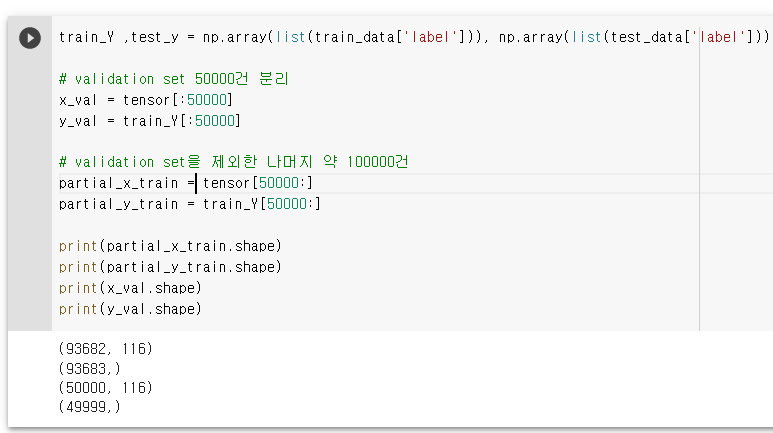

어떤 부분에선가 train 데이터와 test 데이터가 동일하게 전처리되지 않았다. 다시 한번 꼼꼼히 진행하면서(한 코드씩 비교해가면서) 문제를 해결할 수 있었다.


-5. 결과가 나오지 않는 모델

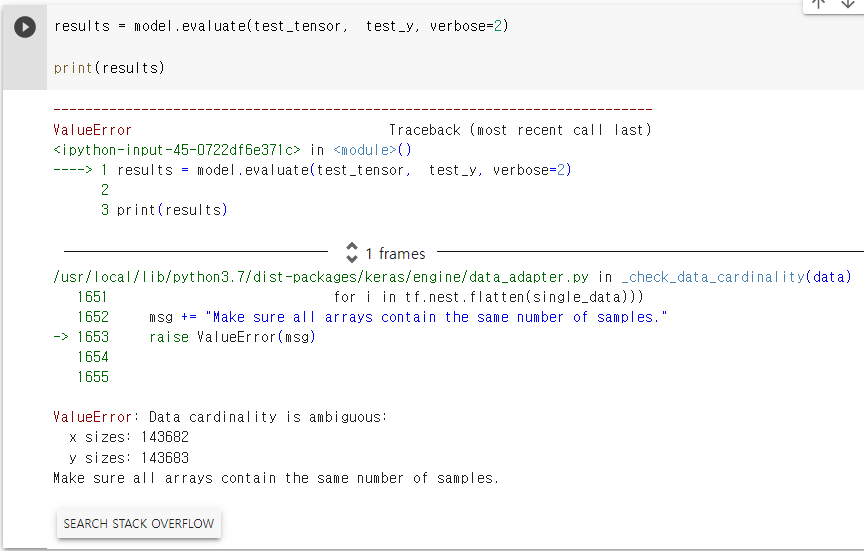

다양한 모델 변경을 해가면서 이전 test 타입과 이후 test 타입에 차이가 있어 나타난 현상이었다. 새로운 변수명을 주어 해결할 수 있었다.

## 3-3. 추후

NLP 학습의 전체적인 큰 그림을 그려보고 싶다.

tokenize 를 사용함과 사용하지 않을 때 padding 이나 임베딩에 차이가 있다.  
tokenizer 를 통해 그런 부분이 해소되기 때문이다. 그래서 처음에    
왜 padding 을 두번 해주는지 등 이해가 안되는 부분이 많았다.  

전체적인 그림을 그릴 수 있다면 이런 문제가 해소될 것이다.